In [1]:
import pandas as pd
import numpy as np

from src import plot

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb

## Mehrere Durchläufe auswerten

In [8]:
import pandas as pd
import numpy as np
import os

# Anzahl der Durchläufe
num_iterations = 20

# Deine Modelle und ihre Metriken
MLA = [
    ('Gradient Boosting', xgb.XGBRegressor())
]

# Input-Verzeichnis definieren
input_dir = 'data/PSO/'  # Hier den Pfad zu deinen Eingabedaten setzen
fs_methode = "pso"
# Listen für das Zusammenführen von Metriken und Vorhersagen
all_metrics = []
all_predictions = []

for model_name, model_instance in MLA:
    for iteration in range(1, num_iterations + 1):
        try:
            # Metriken laden
            metrics_file = os.path.join(input_dir, f'{iteration:02d}_FS_{fs_methode}_metrics.csv')
            df_metrics = pd.read_csv(metrics_file)
            df_metrics['Model_name'] = model_name
            df_metrics['Iteration'] = iteration
            all_metrics.append(df_metrics)

            # Predictions laden
            predictions_file = os.path.join(input_dir, f'{iteration:02d}_FS_{fs_methode}_predictions.csv')
            df_predictions = pd.read_csv(predictions_file)
            df_predictions['Model_name'] = model_name
            df_predictions['Iteration'] = iteration
            all_predictions.append(df_predictions)

        except FileNotFoundError:
            print(f"Datei für Durchlauf {iteration} des Modells {model_name} nicht gefunden. Überspringen.")

# Überprüfen, ob Metriken geladen wurden
if not all_metrics:
    raise ValueError("Keine CSV-Dateien geladen. Bitte überprüfen Sie die Pfade und Dateinamen.")

# Metriken zusammenführen
df_all_metrics = pd.concat(all_metrics, ignore_index=True)

# Nur numerische Spalten für die Berechnung der Mittelwerte auswählen
numeric_columns = df_all_metrics.select_dtypes(include=[np.number]).columns

# Berechnung des Mittelwerts für alle Metriken
mean_metrics = df_all_metrics.groupby('Model_name')[numeric_columns].mean()

# Ergebnisse für die Metriken
results_metrics = mean_metrics.to_dict(orient='index')

# Predictions zusammenführen
df_all_predictions = pd.concat(all_predictions, ignore_index=True)

# Durchschnittliche Predictions berechnen
restored_predictions = {}
for model_name in df_all_predictions['Model_name'].unique():
    model_data = {}
    model_df = df_all_predictions[df_all_predictions['Model_name'] == model_name]
    
    # Iteriere über die einzigartigen Datentypen im Modell
    for data_type in model_df['Data_type'].unique():
        values = model_df[model_df['Data_type'] == data_type]['Value'].values

        # Berechne den Durchschnitt für die Predictions
        avg_values = np.mean(values.reshape(num_iterations, -1), axis=0)
        model_data[data_type] = avg_values
    restored_predictions[model_name] = model_data

results_pred = {model_name: {**{'Model_name': model_name}, **model_data} for model_name, model_data in restored_predictions.items()}

# Beste und schlechteste Metrik finden
best_metrics = df_all_metrics.loc[df_all_metrics.groupby('Model_name')['TestMAE'].idxmin()]
worst_metrics = df_all_metrics.loc[df_all_metrics.groupby('Model_name')['TestMAE'].idxmax()]

# Beste und schlechteste CV Train Metriken finden
best_cv_train_mae = df_all_metrics.loc[df_all_metrics.groupby('Model_name')['CV_TrainMAE'].idxmin()]
worst_cv_train_mae = df_all_metrics.loc[df_all_metrics.groupby('Model_name')['CV_TrainMAE'].idxmax()]

best_cv_train_rmse = df_all_metrics.loc[df_all_metrics.groupby('Model_name')['CV_TrainRMSE'].idxmin()]
worst_cv_train_rmse = df_all_metrics.loc[df_all_metrics.groupby('Model_name')['CV_TrainRMSE'].idxmax()]

# Geringste und höchste Feature-Anzahl finden
min_features = df_all_metrics.loc[df_all_metrics.groupby('Model_name')['Feature-Anzahl'].idxmin()]
max_features = df_all_metrics.loc[df_all_metrics.groupby('Model_name')['Feature-Anzahl'].idxmax()]

# Durchschnittliche Metrik und durchschnittliche Feature-Anzahl nach Model aufteilen
avg_metric_by_model = df_all_metrics.groupby('Model_name')[['TestMAE', 'TestRMSE', 'CV_TrainMAE', 'CV_TrainRMSE']].mean()
avg_feature_count_by_model = df_all_metrics.groupby('Model_name')['Feature-Anzahl'].mean()
avg_time_to_find_features_by_model = df_all_metrics.groupby('Model_name')['FS-Laufzeit'].mean()

# Ergebnisse ausgeben
for model_name in MLA:
    print(f"\nErgebnisse für Modell: {model_name[0]}")
    
    print("\nDurchschnittliche Metriken nach Modell:")
    print(avg_metric_by_model.loc[model_name[0]])

    print("\nDurchschnittliche Feature-Anzahl nach Modell:")
    print(avg_feature_count_by_model.loc[model_name[0]])

    print("\nDurchschnittliche Zeit zum Finden der Features nach Modell:")
    print(avg_time_to_find_features_by_model.loc[model_name[0]])

    print("\nDurchlauf mit der besten Metrik (TestMAE):")
    best_metric = best_metrics[best_metrics['Model_name'] == model_name[0]]
    print(best_metric[['Model_name', 'Iteration', 'TestMAE', 'TestRMSE', 'Feature-Anzahl']].to_string(index=False))

    print("\nDurchlauf mit der schlechtesten Metrik (TestMAE):")
    worst_metric = worst_metrics[worst_metrics['Model_name'] == model_name[0]]
    print(worst_metric[['Model_name', 'Iteration', 'TestMAE', 'Feature-Anzahl']].to_string(index=False))

    print("\nDurchlauf mit der besten CV Train Metrik (CV_TrainMAE):")
    best_cv_train_mae_metric = best_cv_train_mae[best_cv_train_mae['Model_name'] == model_name[0]]
    print(best_cv_train_mae_metric[['Model_name', 'Iteration', 'CV_TrainMAE', 'CV_TrainRMSE']].to_string(index=False))

    print("\nDurchlauf mit der schlechtesten CV Train Metrik (CV_TrainMAE):")
    worst_cv_train_mae_metric = worst_cv_train_mae[worst_cv_train_mae['Model_name'] == model_name[0]]
    print(worst_cv_train_mae_metric[['Model_name', 'Iteration', 'CV_TrainMAE', 'CV_TrainRMSE']].to_string(index=False))

    print("\nDurchlauf mit der besten CV Train Metrik (CV_TrainRMSE):")
    best_cv_train_rmse_metric = best_cv_train_rmse[best_cv_train_rmse['Model_name'] == model_name[0]]
    print(best_cv_train_rmse_metric[['Model_name', 'Iteration', 'CV_TrainRMSE', 'CV_TrainMAE']].to_string(index=False))

    print("\nDurchlauf mit der schlechtesten CV Train Metrik (CV_TrainRMSE):")
    worst_cv_train_rmse_metric = worst_cv_train_rmse[worst_cv_train_rmse['Model_name'] == model_name[0]]
    print(worst_cv_train_rmse_metric[['Model_name', 'Iteration', 'CV_TrainRMSE', 'CV_TrainMAE']].to_string(index=False))

    print("\nDurchlauf mit der geringsten Feature-Anzahl:")
    min_feature = min_features[min_features['Model_name'] == model_name[0]]
    print(min_feature[['Model_name', 'Iteration', 'Feature-Anzahl', 'TestMAE', 'TestRMSE']].to_string(index=False))

    print("\nDurchlauf mit der höchsten Feature-Anzahl:")
    max_feature = max_features[max_features['Model_name'] == model_name[0]]
    print(max_feature[['Model_name', 'Iteration', 'Feature-Anzahl', 'TestMAE', 'TestRMSE']].to_string(index=False))



Ergebnisse für Modell: Gradient Boosting

Durchschnittliche Metriken nach Modell:
TestMAE         36.296476
TestRMSE        73.010894
CV_TrainMAE     18.414775
CV_TrainRMSE    42.685842
Name: Gradient Boosting, dtype: float64

Durchschnittliche Feature-Anzahl nach Modell:
58.5

Durchschnittliche Zeit zum Finden der Features nach Modell:
570.2574999999999

Durchlauf mit der besten Metrik (TestMAE):
       Model_name  Iteration   TestMAE  TestRMSE  Feature-Anzahl
Gradient Boosting         20 32.408355 63.746525              85

Durchlauf mit der schlechtesten Metrik (TestMAE):
       Model_name  Iteration   TestMAE  Feature-Anzahl
Gradient Boosting         13 37.668513             101

Durchlauf mit der besten CV Train Metrik (CV_TrainMAE):
       Model_name  Iteration  CV_TrainMAE  CV_TrainRMSE
Gradient Boosting          2    11.657359     25.881407

Durchlauf mit der schlechtesten CV Train Metrik (CV_TrainMAE):
       Model_name  Iteration  CV_TrainMAE  CV_TrainRMSE
Gradient Boosting 

## Metrik vs. Feature Anzahl

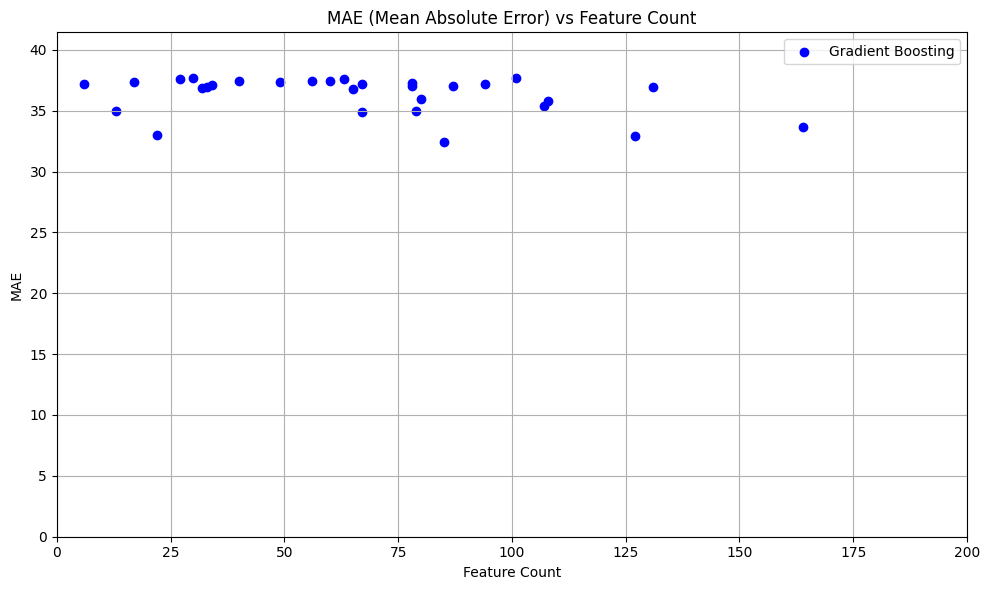

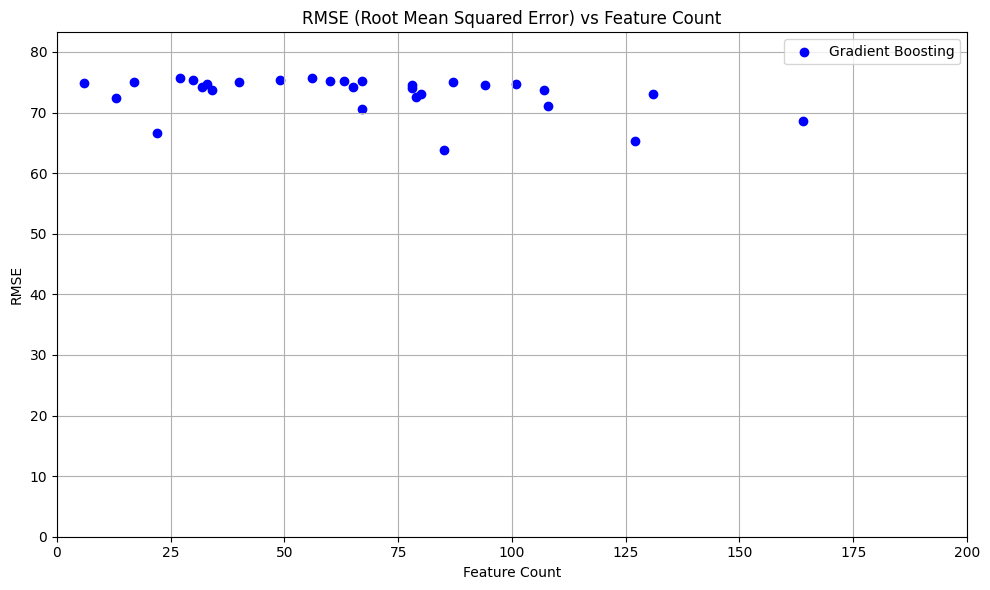

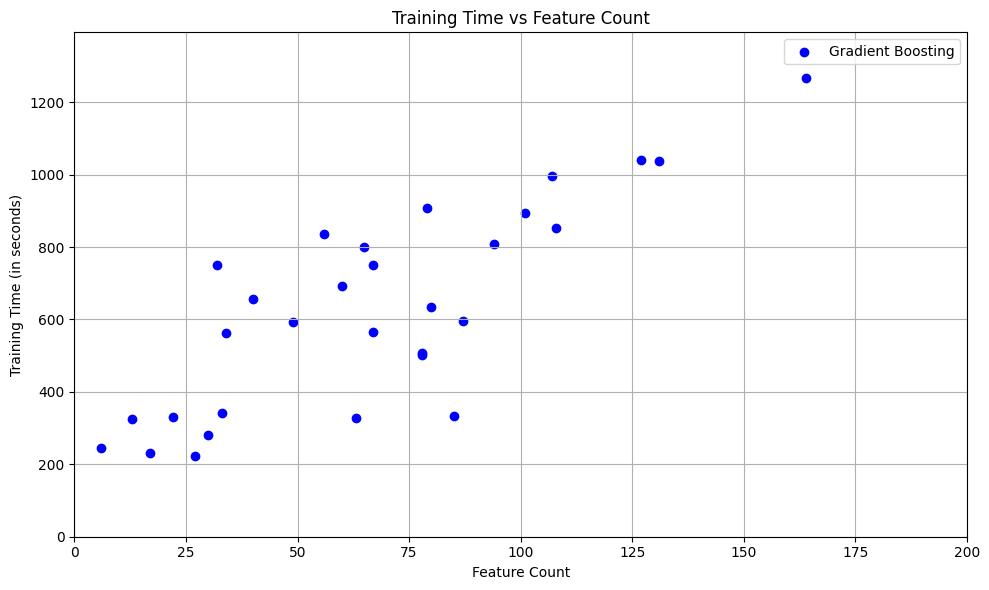

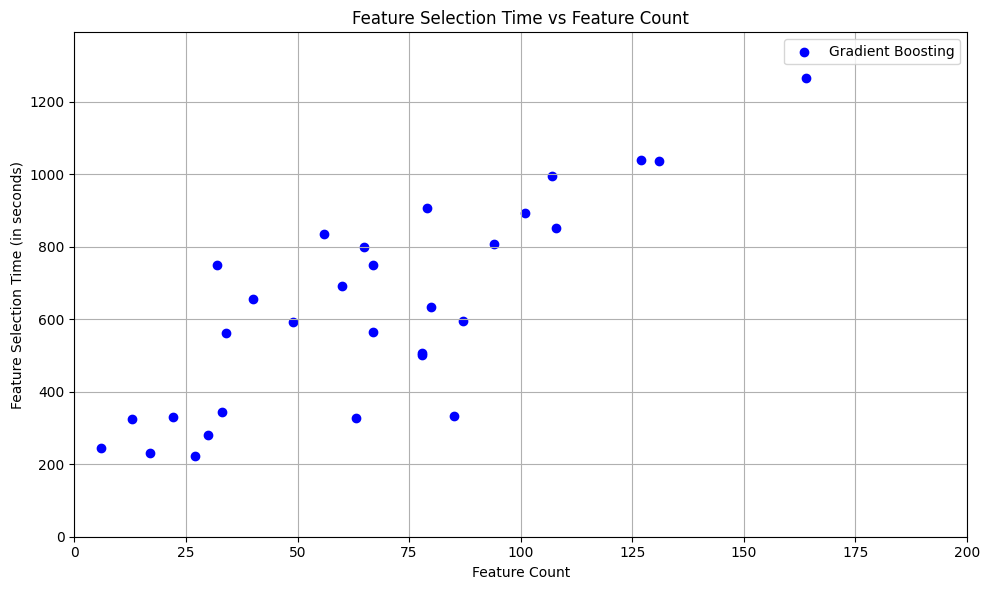

Anzahl Feature Counts: 28
Anzahl CV Train MAE für Gradient Boosting: 30


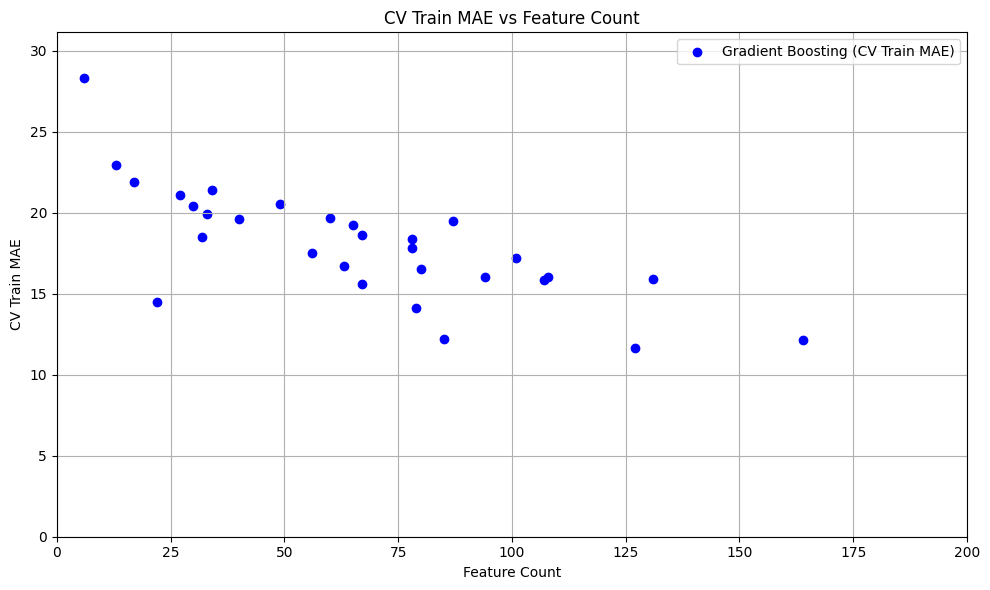

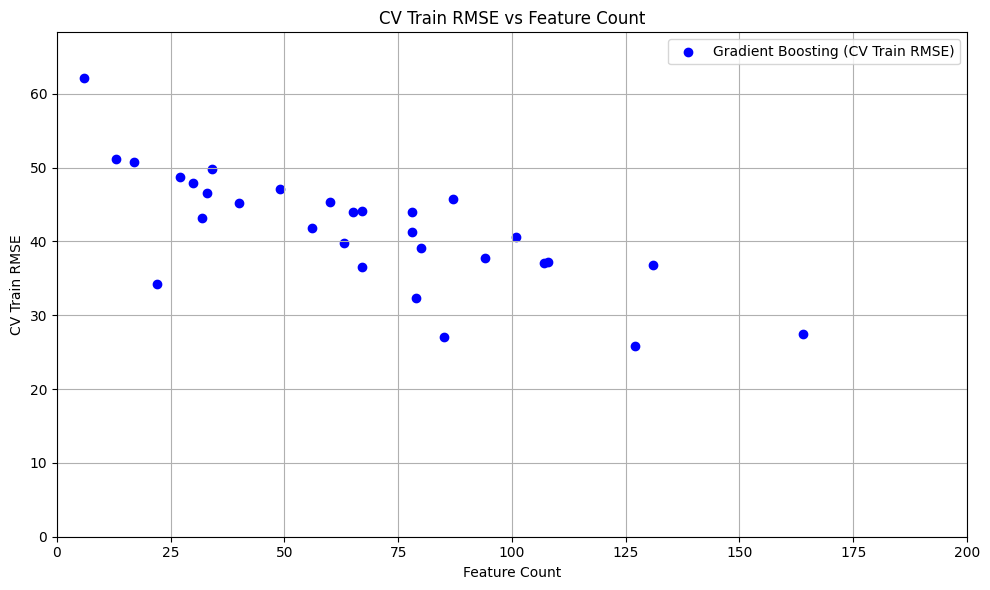

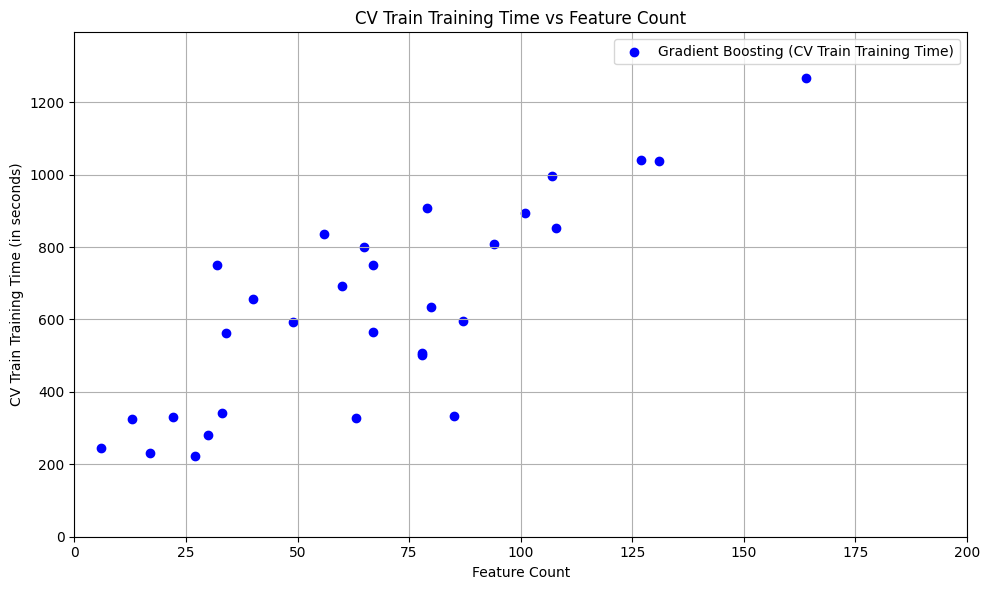

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Verzeichnis mit den gespeicherten Ergebnissen
input_dir = "data/PSO/"  # Verzeichnis mit den Daten
save_path = "plots/PSO"  # Verzeichnis zum Speichern der Plots
fs_methode = "pso" # Beispiel Feature-Auswahlmethoden
# Sicherstellen, dass der Ordner existiert, andernfalls erstellen
os.makedirs(save_path, exist_ok=True)

# Modellnamen und Farben für den Plot
models = ['Gradient Boosting']
colors = ['b']  # Farben für Modelle

# Listen, um die Metriken zu speichern
mae_values = {model: [] for model in models}
rmse_values = {model: [] for model in models}
train_time_values = {model: [] for model in models}  # Liste für Laufzeit
fs_time_values = {model: [] for model in models}  # Liste für Feature Selection Laufzeit
feature_counts = []  # Liste, die später mit den Feature-Anzahlen gefüllt wird
cv_train_mae_values = {model: [] for model in models}  # Liste für CV Train MAE
cv_train_rmse_values = {model: [] for model in models}  # Liste für CV Train RMSE
cv_train_time_values = {model: [] for model in models}  # Liste für CV Train Laufzeit


# Iteriere über jede Feature-Auswahlmethode und jedes Modell

for iteration in range(1, 31):  # 30 Durchläufe
    # Pfad zur Metrik-Datei
    metrics_file = os.path.join(input_dir, f'{iteration:02d}_FS_{fs_methode}_metrics.csv')

    try:
        # Lese die Metriken ein
        df_metrics = pd.read_csv(metrics_file)

        # Extrahiere die Feature-Anzahl (Feature-Anzahl ist eine Spalte in den Metriken)
        feature_counts.extend(df_metrics['Feature-Anzahl'].unique())

        # Extrahiere die MAE, RMSE, Laufzeit und Feature Selection Laufzeit Werte für jedes Modell
        for model in models:
            mae_values[model].append(df_metrics.loc[df_metrics['Model_name'] == model, 'TestMAE'].values[0])
            rmse_values[model].append(df_metrics.loc[df_metrics['Model_name'] == model, 'TestRMSE'].values[0])
            train_time_values[model].append(df_metrics.loc[df_metrics['Model_name'] == model, 'TrainTime_ges'].values[0])  # Laufzeit
            fs_time_values[model].append(df_metrics.loc[df_metrics['Model_name'] == model, 'FS-Laufzeit'].values[0])  # FS Laufzeit
            
             # Extrahiere CV-Train Metriken
            cv_train_mae_values[model].append(df_metrics.loc[df_metrics['Model_name'] == model, 'CV_TrainMAE'].values[0])
            cv_train_rmse_values[model].append(df_metrics.loc[df_metrics['Model_name'] == model, 'CV_TrainRMSE'].values[0])
            cv_train_time_values[model].append(df_metrics.loc[df_metrics['Model_name'] == model, 'CV_fit_time_ges'].values[0])  # CV Laufzeit

    except FileNotFoundError:
        print(f"Datei für Iteration {iteration} und Feature-Auswahlmethode {fs_methode} nicht gefunden. Überspringen.")

# Berechne den maximalen Wert für die Metriken MAE, RMSE, Laufzeit und FS Laufzeit, um die y-Achse dynamisch anzupassen
max_mae = max(max(mae_values[model]) for model in models)
max_rmse = max(max(rmse_values[model]) for model in models)
max_train_time = max(max(train_time_values[model]) for model in models)
max_fs_time = max(max(fs_time_values[model]) for model in models)
max_cv_train_mae = max(max(cv_train_mae_values[model]) for model in models)
max_cv_train_rmse = max(max(cv_train_rmse_values[model]) for model in models)
max_cv_train_time = max(max(cv_train_time_values[model]) for model in models)


# Plotte MAE (nur Punkte, keine Linien)
plt.figure(figsize=(10, 6))
for model, color in zip(models, colors):
    plt.scatter(feature_counts, mae_values[model], label=model, color=color)  # scatter für nur Punkte

# Achsen und Titel setzen
plt.title('MAE (Mean Absolute Error) vs Feature Count')
plt.xlabel('Feature Count')
plt.ylabel('MAE')
plt.xlim(0, 200)  # Setze die x-Achse von 0 bis 200
plt.ylim(0, max_mae * 1.1)  # Setze die y-Achse bei 0, mit etwas Platz über dem höchsten Wert
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'mae_vs_feature_count.png'))
plt.show()

# Plotte RMSE (nur Punkte, keine Linien)
plt.figure(figsize=(10, 6))
for model, color in zip(models, colors):
    plt.scatter(feature_counts, rmse_values[model], label=model, color=color)  # scatter für nur Punkte

# Achsen und Titel setzen
plt.title('RMSE (Root Mean Squared Error) vs Feature Count')
plt.xlabel('Feature Count')
plt.ylabel('RMSE')
plt.xlim(0, 200)  # Setze die x-Achse von 0 bis 200
plt.ylim(0, max_rmse * 1.1)  # Setze die y-Achse bei 0, mit etwas Platz über dem höchsten Wert
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'rmse_vs_feature_count.png'))
plt.show()

# Plotte Laufzeit (nur Punkte, keine Linien)
plt.figure(figsize=(10, 6))
for model, color in zip(models, colors):
    plt.scatter(feature_counts, train_time_values[model], label=model, color=color)  # scatter für nur Punkte


# Achsen und Titel setzen
plt.title('Training Time vs Feature Count')
plt.xlabel('Feature Count')
plt.ylabel('Training Time (in seconds)')
plt.xlim(0, 200)  # Setze die x-Achse von 0 bis 200
plt.ylim(0, max_train_time * 1.1)  # Setze die y-Achse bei 0, mit etwas Platz über dem höchsten Wert
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'train_time_vs_feature_count.png'))
plt.show()

# Plotte Feature Selection Laufzeit (nur Punkte, keine Linien)
plt.figure(figsize=(10, 6))
for model, color in zip(models, colors):
    plt.scatter(feature_counts, fs_time_values[model], label=model, color=color)  # scatter für nur Punkte


# Achsen und Titel setzen
plt.title('Feature Selection Time vs Feature Count')
plt.xlabel('Feature Count')
plt.ylabel('Feature Selection Time (in seconds)')
plt.xlim(0, 200)  # Setze die x-Achse von 0 bis 200
plt.ylim(0, max_fs_time * 1.1)  # Setze die y-Achse bei 0, mit etwas Platz über dem höchsten Wert
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'fs_time_vs_feature_count.png'))
plt.show()


# Plotte CV Train MAE (nur Punkte, keine Linien)
plt.figure(figsize=(10, 6))
for model, color in zip(models, colors):
    plt.scatter(feature_counts, cv_train_mae_values[model], label=f"{model} (CV Train MAE)", color=color)  # scatter für nur Punkte

# Achsen und Titel setzen
plt.title('CV Train MAE vs Feature Count')
plt.xlabel('Feature Count')
plt.ylabel('CV Train MAE')
plt.xlim(0, 200)  # Setze die x-Achse von 0 bis 200
plt.ylim(0, max_cv_train_mae * 1.1)  # Setze die y-Achse bei 0, mit etwas Platz über dem höchsten Wert
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'cv_train_mae_vs_feature_count.png'))
plt.show()

# Plotte CV Train RMSE (nur Punkte, keine Linien)
plt.figure(figsize=(10, 6))
for model, color in zip(models, colors):
    plt.scatter(feature_counts, cv_train_rmse_values[model], label=f"{model} (CV Train RMSE)", color=color)  # scatter für nur Punkte

# Achsen und Titel setzen
plt.title('CV Train RMSE vs Feature Count')
plt.xlabel('Feature Count')
plt.ylabel('CV Train RMSE')
plt.xlim(0, 200)  # Setze die x-Achse von 0 bis 200
plt.ylim(0, max_cv_train_rmse * 1.1)  # Setze die y-Achse bei 0, mit etwas Platz über dem höchsten Wert
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'cv_train_rmse_vs_feature_count.png'))
plt.show()

# Plotte CV Train Training Time (nur Punkte, keine Linien)
plt.figure(figsize=(10, 6))
for model, color in zip(models, colors):
    plt.scatter(feature_counts, cv_train_time_values[model], label=f"{model} (CV Train Training Time)", color=color)  # scatter für nur Punkte

# Achsen und Titel setzen
plt.title('CV Train Training Time vs Feature Count')
plt.xlabel('Feature Count')
plt.ylabel('CV Train Training Time (in seconds)')
plt.xlim(0, 200)  # Setze die x-Achse von 0 bis 200
plt.ylim(0, max_cv_train_time * 1.1)  # Setze die y-Achse bei 0, mit etwas Platz über dem höchsten Wert
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'cv_train_train_time_vs_feature_count.png'))
plt.show()

## Einen Durchlauf auswerten

In [13]:
df_metris = pd.read_csv("data/PSO/20_FS_pso_metrics.csv") #Hier je nach gewünschten Plots csv-Datei austauschen
df_metris.set_index('Model_name', inplace=True)
results_metrics = df_metris.to_dict(orient="index")


restored_df = pd.read_csv('data/PSO/20_FS_pso_predictions.csv')#Hier je nach gewünschten Plots csv-Datei austauschen
restored_predictions = {}

# Iteriere über die einzigartigen Modellnamen im DataFrame
for model_name in restored_df['Model_name'].unique():
    model_data = {}
    model_df = restored_df[restored_df['Model_name'] == model_name]
    # Iteriere über die einzigartigen Datentypen im Modell
    for data_type in model_df['Data_type'].unique():
        values = model_df[model_df['Data_type'] == data_type]['Value'].values
        # Füge die Werte zum Modelldaten-Dictionary hinzu
        model_data[data_type] = values
    # Füge das Modelldaten-Dictionary zum Hauptdictionary hinzu
    restored_predictions[model_name] = model_data
results_pred = {model_name: {**{'Model_name': model_name}, **model_data} for model_name, model_data in restored_predictions.items()}

evaluation = ['train', 'cv_train', 'cv_test',  'test']

MLA = [
    #('Linear Regressor',LinearRegression()),
    #('SVR', SVR(kernel='linear')),
    #('Random Forest',RandomForestRegressor()),
    ('Gradient Boosting', xgb.XGBRegressor())
]

## Scatterplots Predictions

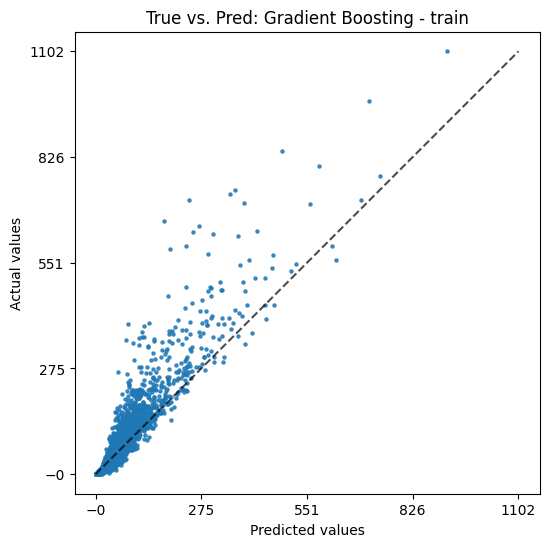

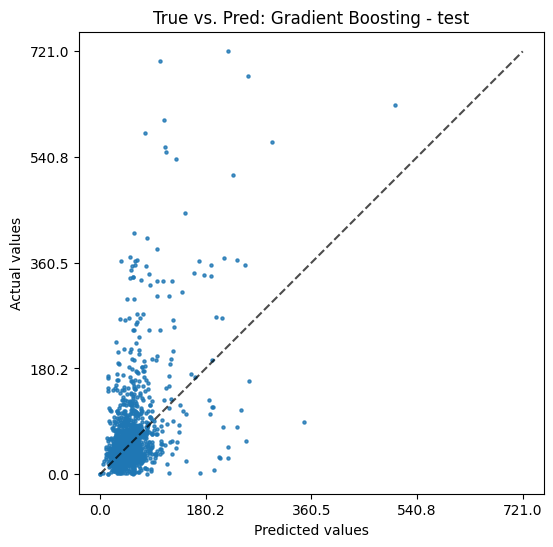

In [14]:
num_features = 20
selection_methode = "PSO"
for item in evaluation:
    for model_name, model_instance in MLA:
        plot.predicitons_scatter(selection_methode, results_pred[model_name], evaluation=item,name=(str(num_features)+"_PSO_"))

## Histogramm Residuen

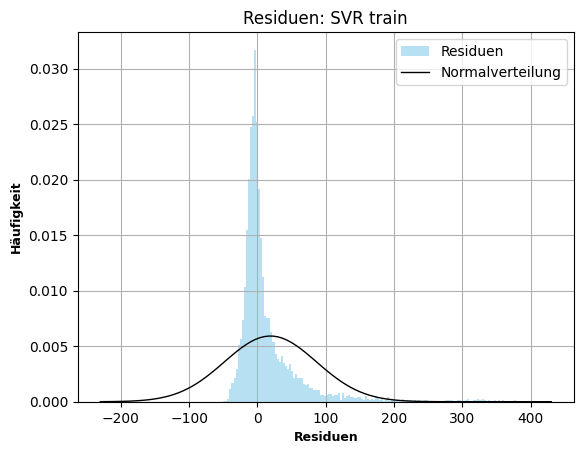

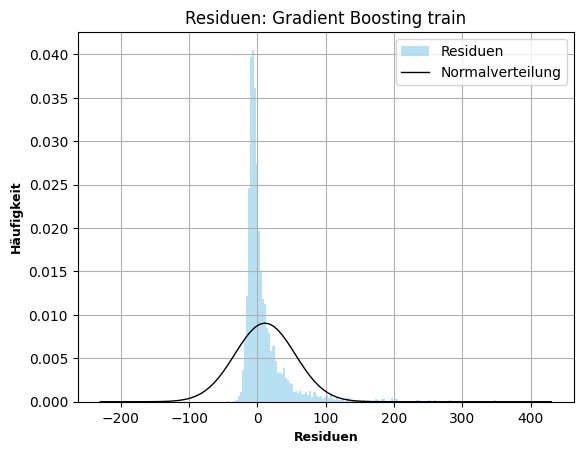

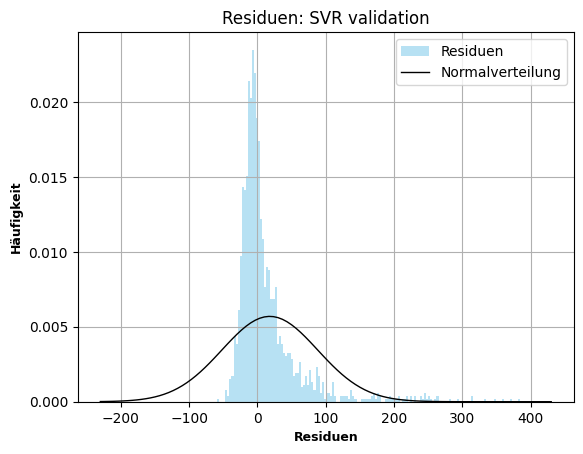

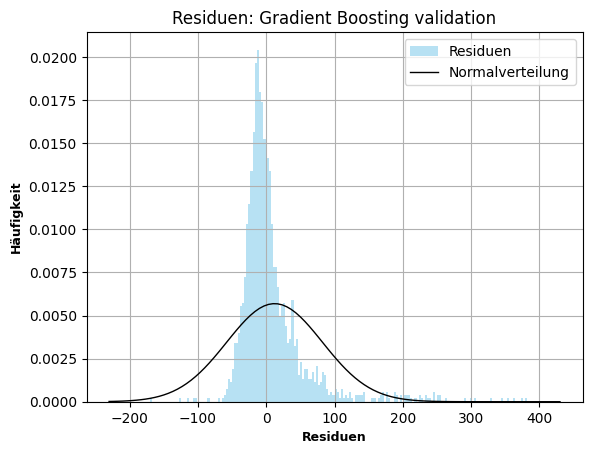

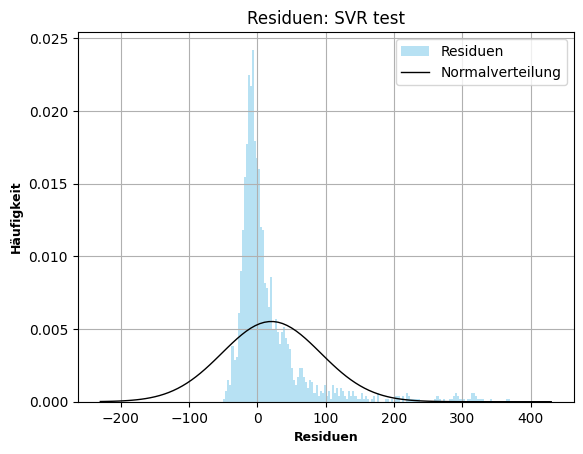

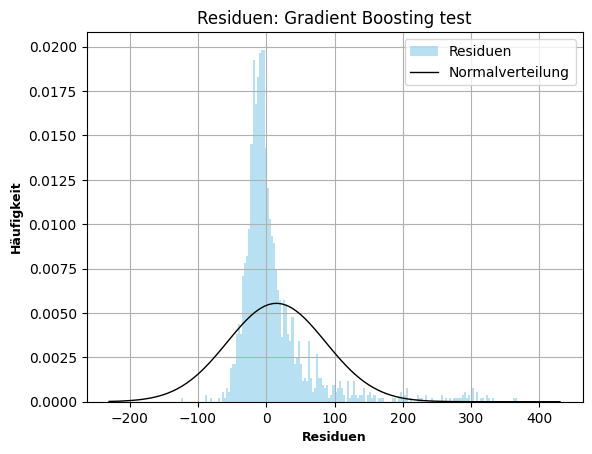

In [11]:
for item in evaluation:
    for model_name, model_instance in MLA:
        plot.residuen_histo(results_pred[model_name], evaluation=item, name="All_FS_psoqx", range_min=-200, range_max=400)#Hier ebenfalls den Namen ändern je nach Algorithmus

## Barplots Metrics

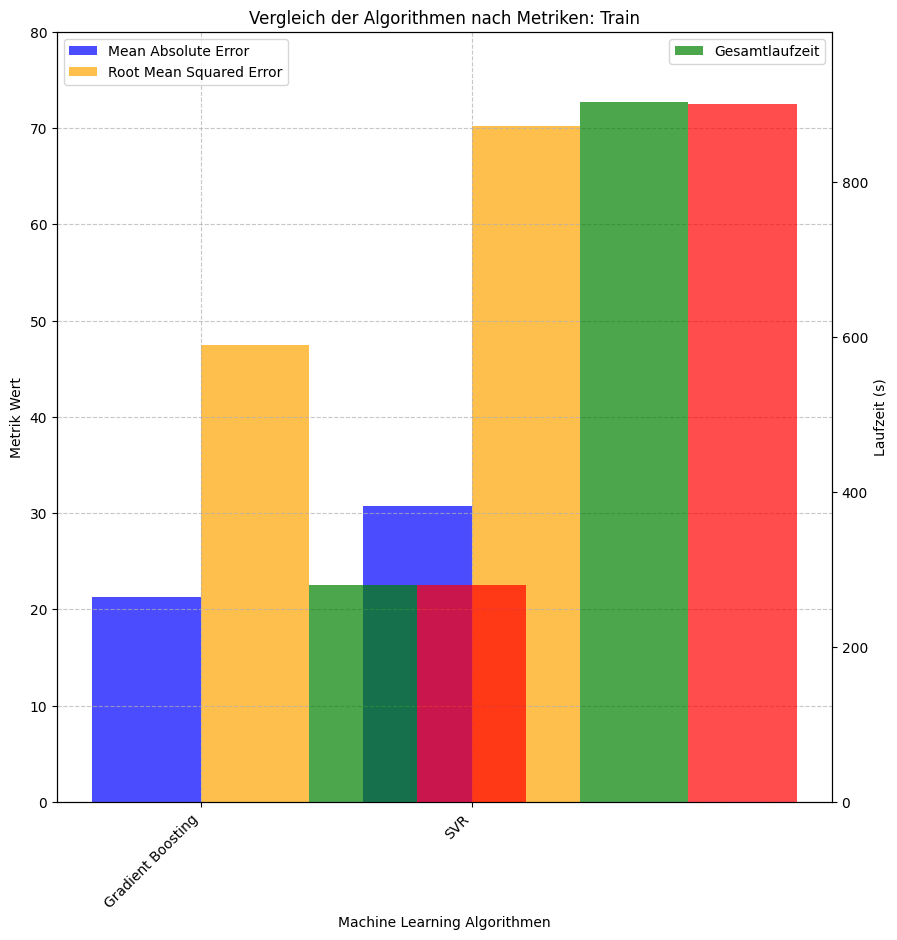

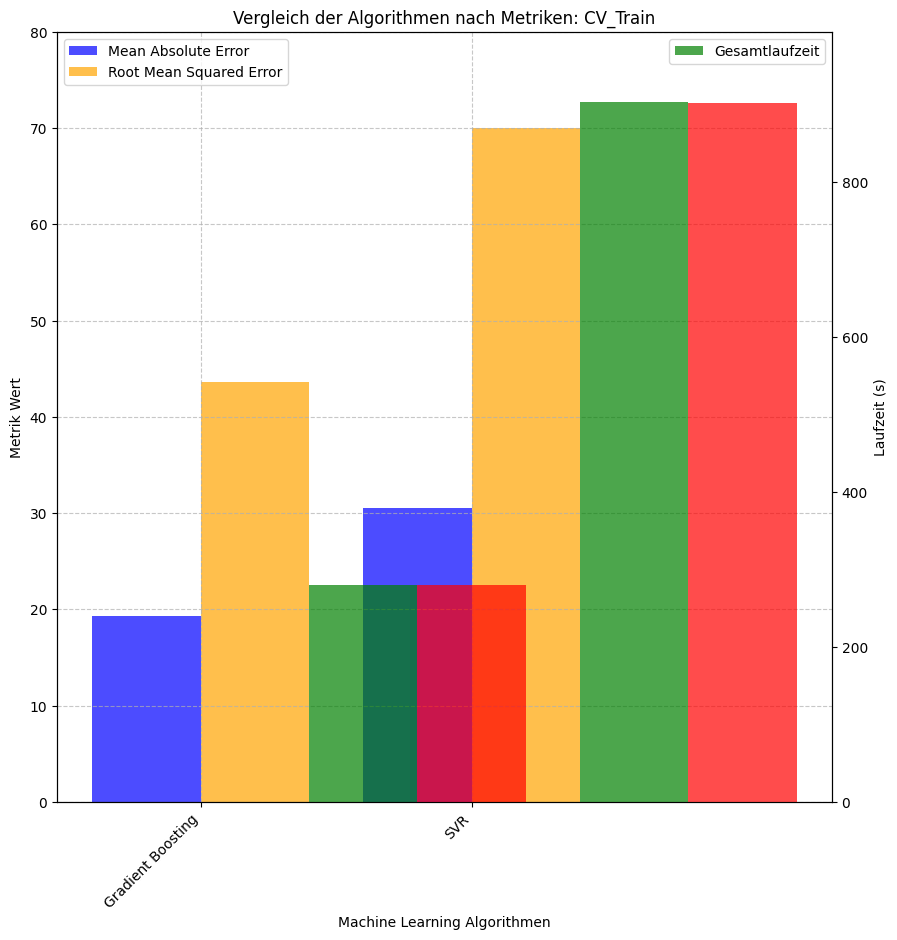

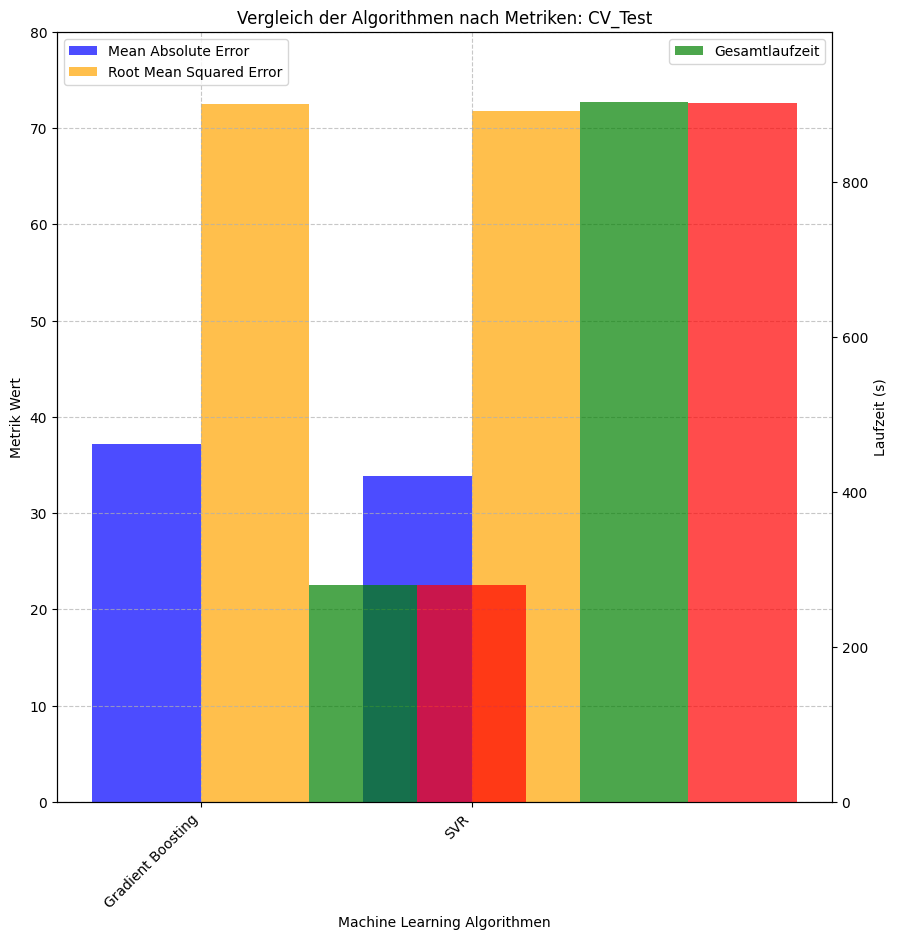

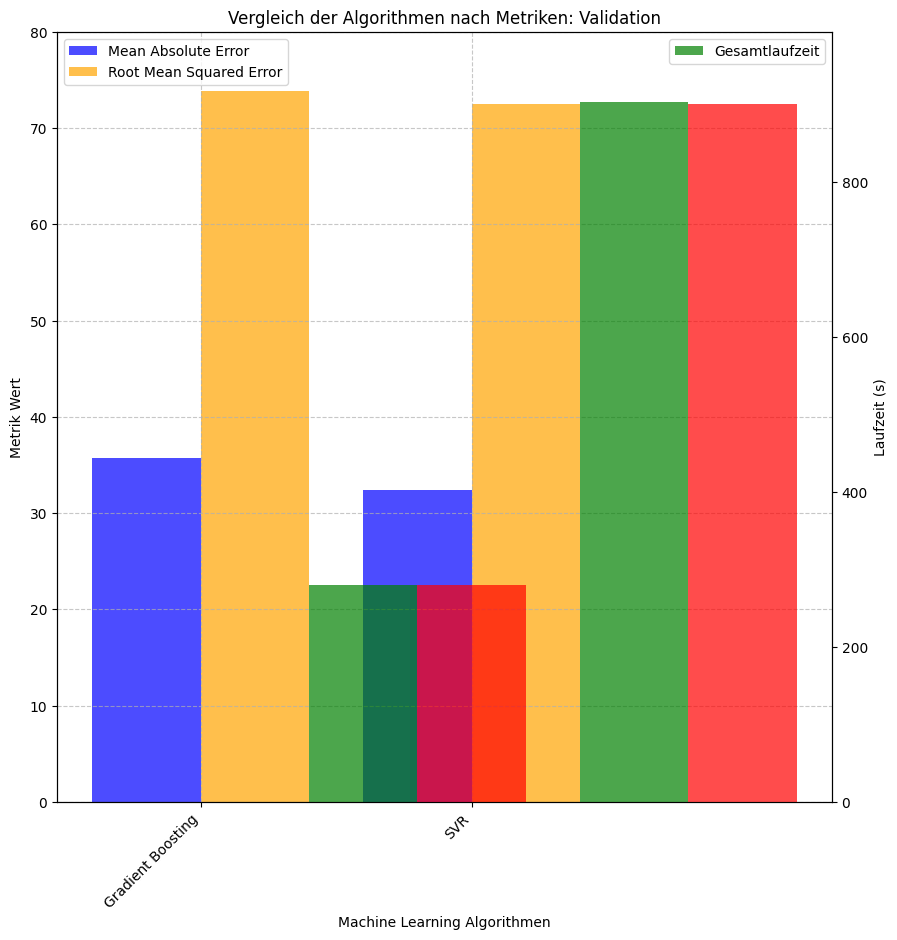

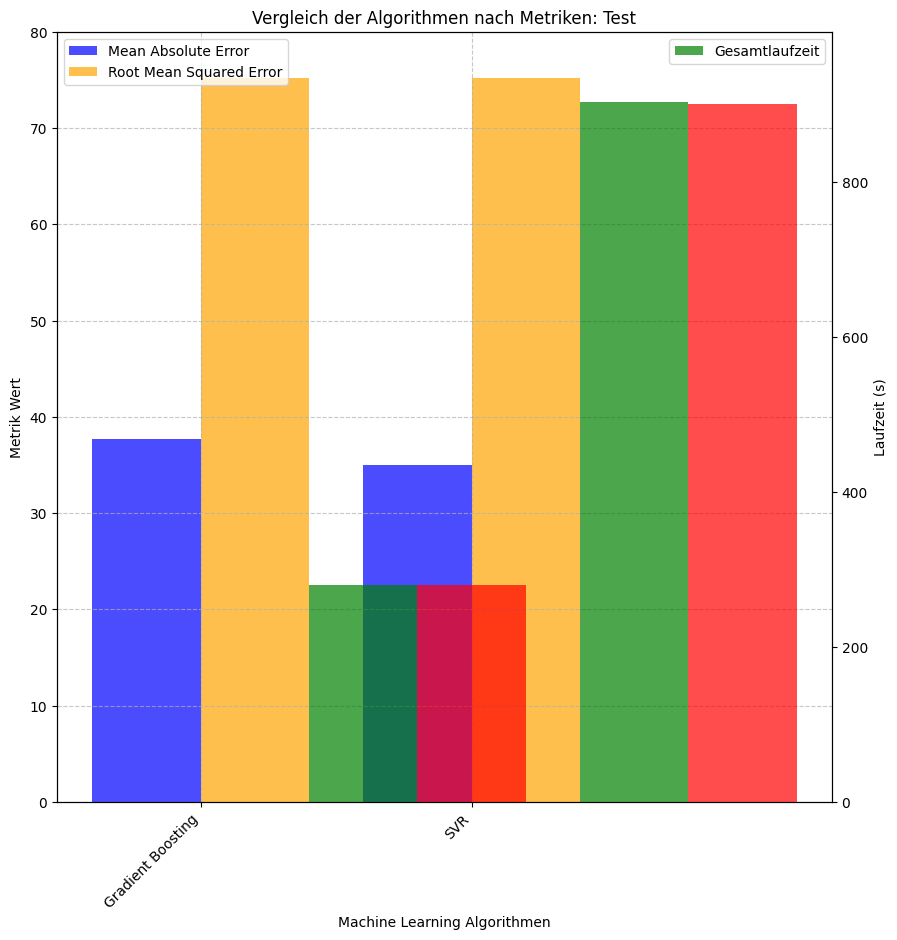

In [12]:
for item in evaluation:
    plot.model_results_barplot(results_metrics, metrics_upper_limit=80, runtime_upper_limit=None, plot_runtime=True, evaluation=item,name="All_FS_corr", FS=True)#Hier ebenfalls den Namen ändern je nach Algorithmus